<a href="https://colab.research.google.com/github/ghamawell/crawling-data-by-twitter/blob/main/Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis

## Introduction

Dalam dunia retail, kita dapat menggunakan beberapa metode yang bisa digunakan untuk melakukan sebuah analisis pada data. Ada sebuah metode yang dapat di gunakan untuk melihat pola dari sebuah data yang besar salah satunya yaitu Acossiation Rule menggunakan algoritma apriori,  dimana algoritma tersebut dapat mencari asosiasi/hubungan antara data yang saling berkaitan. Salah satu penerapannya yang sering dipakai yaitu market basket analysis. Secara sederhana, terdapat beberapa istilah yang akan sering di gunakan pada Acossiation Rule antara lain:

**Support** merupakan indikasi dari seberapa sering itemset muncul di dataset.

**Confidence** merupakan indikasi dari seberapa sering aturan itu terbukti benar.

**Lift Ratio** merupakan rasio dari nilai pengamatan Support yang diharapkan jika dua aturan itu independen.


### Data Understanding

Data yang di gunakan merupakan data transaksi dari sebuah pusat grosir yang melayani transaksi di beberapa negara

Datanya terdiri dari 8 Variabel


1.   Invoice No : Nomor nota pada setiap pembelian
2.   Stock Code : Merupakan kode stok dari sebuah barang
3.   Description : Deskripsi dari barang tersebut.
4.   Quantitiy : Jumlah barang yang di beli pada sebuah transaksi.
5.   Invoice date : tanggal pembelian
6.   Unit Price : Harga per unit barang
7.   Customer ID : ID Dari pelanggan
8.   Country : Negara dari pelangan.


### Requirement

Ada beberapa library python yang di gunakan untuk coding ini:

Pandas : Untuk melakukan operasi pada dataframe

mlxtend : Library untuk machine learning

Silahkan melakukan installasi dengan pip install jika belum diinstall

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from urllib.request import urlopen

Lakukan Import library,  pertama adalah pandas nanti di sebut sebagai pd. Kemudian mlxtend melakukan import fungsi apriori dan association_rules. yang ketiga yaitu untuk mendownload dataset dari url

In [ ]:
link = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
socket = urlopen(link)

df = pd.read_excel(socket)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Pertama-tama adalah membaca file excel menngunakan library pandas. Dimana nama file excel yang di gunakan adalah 'Online Retail.xlsx' yang kita download dari UCI, jika sudah berhasil maka akan muncul head tabel dari data tersebut.

Kemudian selanjutnya adalah melakukan cleaning data dimana menghilangkan beberapa spasi , menghapus variabel invoiceNo yang kosong, dan menghilangkan Transaksi yang merupakan transaksi kredit (Di awali dengan hufuf C pada invoice number)


In [ ]:
# Hapus spasi
df['Description'] = df['Description'].str.strip()

# Hapus InvoiceNo yang kosong
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

# Ubah type data menjadi str
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

# Hapus transaksi kredit (Di awali dengan hufuf C pada invoice number)
df = df[~df['InvoiceNo'].str.contains('C')]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


WHITE HANGING HEART T-LIGHT HOLDER    2327
JUMBO BAG RED RETROSPOT               2115
REGENCY CAKESTAND 3 TIER              2019
PARTY BUNTING                         1707
LUNCH BAG RED RETROSPOT               1594
ASSORTED COLOUR BIRD ORNAMENT         1489
SET OF 3 CAKE TINS PANTRY DESIGN      1399
PACK OF 72 RETROSPOT CAKE CASES       1370
LUNCH BAG  BLACK SKULL.               1328
NATURAL SLATE HEART CHALKBOARD        1263
Name: Description, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

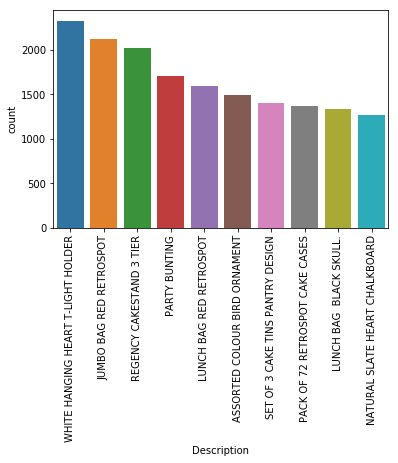

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
display (df['Description'].value_counts().iloc[:10])
sns.countplot(x = 'Description', data = df, order = df['Description'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)

Setelah membersihkan data, selanjutnya adalah membuat sebuah keranjang belanja yang di kenali berdasarkan nomor invoice, yang berasal dari negara prancis saja.

In [ ]:
# memilih country prancis saja, Mejumlahkan quantity, melakukan pivot, reset index, mengisi null dengan 0, reindex berdasarkan invoince number
basket = (df[df['Country'] =="France"].groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D DOG PICTURE PLAYING CARDS,3D HEARTS HONEYCOMB PAPER GARLAND,3D SHEET OF DOG STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,...,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nanti akan muncul seperti pada gambar di atas. dimana jika jumlah barang ada maka nilai 0 akan diganti sesuai jumlah barang pada masing-masing invoice(nomor nota).

Kemudian melakukan encoding, dimana jika barang kurang dari sama dengan 0 maka keranjang tersebut bernilai 0 dan jika lebih dari 1 maka nilainya adalah 1, sehingga jika sebuah nota membeli barang A sebanyak 10 buah maka hanya akan dihitung 1. Karena analisis yang di gunakan menyaratkan seperti itu.

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)
 
#menghapus kolom postage
basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D DOG PICTURE PLAYING CARDS,3D HEARTS HONEYCOMB PAPER GARLAND,3D SHEET OF DOG STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,...,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Selanjutnya adalah membuat variabel dimana terdiri dari beberapa barang yang sering / terbeli dari seluruh transaksi menggunakan perintah apriori

In [ ]:
# Build up the frequent items 
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.071429,(4 TRADITIONAL SPINNING TOPS)
1,0.096939,(ALARM CLOCK BAKELIKE GREEN)
2,0.102041,(ALARM CLOCK BAKELIKE PINK)
3,0.094388,(ALARM CLOCK BAKELIKE RED)
4,0.081633,(BAKING SET 9 PIECE RETROSPOT)


Dimana perintah yang di gunakan adalah apriori, dengan data dari basket_sets dengan minimum nilai support 0.07/ 7%.
Maka hasilnya akan seperti di atas.


## Association Rule

Selanjutnya adalah membangun sebuah variabel yang memiliki aturan aturan asosiasi dari masin-masing barang, variabel rulesmerupakan hasil dari fungsi yang mencari asosiasi dimana data yang di gunakan berasal dari frequent_items , dengan nilai minium dari lift ratio nya adalah 1

In [ ]:
# Create the rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules#.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
5,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273
7,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.125000,0.099490,0.071429,0.571429,5.743590,0.058992,2.101190
8,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.168367,0.137755,0.089286,0.530303,3.849607,0.066092,1.835747
9,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.137755,0.168367,0.089286,0.648148,3.849607,0.066092,2.363588


Bisa dilihat pada gambar di atas, barang Alarm clock bakelike green biasanya terbeli bersamaan dengan Alarm Clock bakelike pinkdengan nilai support 0.096939.

nb: Untuk mengetahui apa itu support dan lift ratio bisa baca disini

Kemudian selanjutnya adalah melakukan filter untuk nilai lift ratio minimal 6 dan tingkat confidence minimal 0.8

In [ ]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
17,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.127551,0.132653,0.102041,0.800000,6.030769,0.085121,4.336735
18,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.137755,0.127551,0.122449,0.888889,6.968889,0.104878,7.852041
19,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.127551,0.137755,0.122449,0.960000,6.968889,0.104878,21.556122
20,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959
21,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.122449,0.132653,0.099490,0.812500,6.125000,0.083247,4.625850
22,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796


Sehingga didapatkan beberapa aturan seperti di atas.